# HGCAL FE studies

### imports and initial setup

In [2]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal

from time import sleep
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly as py

from descartes import PolygonPatch
from tqdm import tqdm_notebook

import scripts.helpers as hlp
from skhep.modeling import bayesian_blocks

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 16})

#%connect_info

/home/naodell/work/hgcal


### Open data that has been converted to dataframes

In [21]:
infile = open('data/v2/ttbar_14TeV_200PU/output_0.pkl', 'rb')
gen = pickle.load(infile)
data = pickle.load(infile)
df_all = pd.concat(data)

features = ['zside', 'layer', 'sector', 'panel', 'cell', 'subdet',
            'x', 'y', 'z', 'phi', 'eta',
            'pt', 'reco_e', 'sim_e']

### Visualizations of detector hits, panels, and occupancies

In [4]:
# find event with gen electron passing through sector 1 on the +z side
layer = 7
sector = 1
panel = 4
ievt = 0
dphi_min = np.pi
for i, part in enumerate(gen):
    e1 = part.iloc[0]
    e2 = part.iloc[1]
    
    dphi = abs(e1.phi - np.pi) if e1.phi > 0 else abs(np.pi + e1.phi)
    #print(i, e1.phi, dphi)
    if dphi < dphi_min:
        ievt = i
        dphi_min = dphi
       

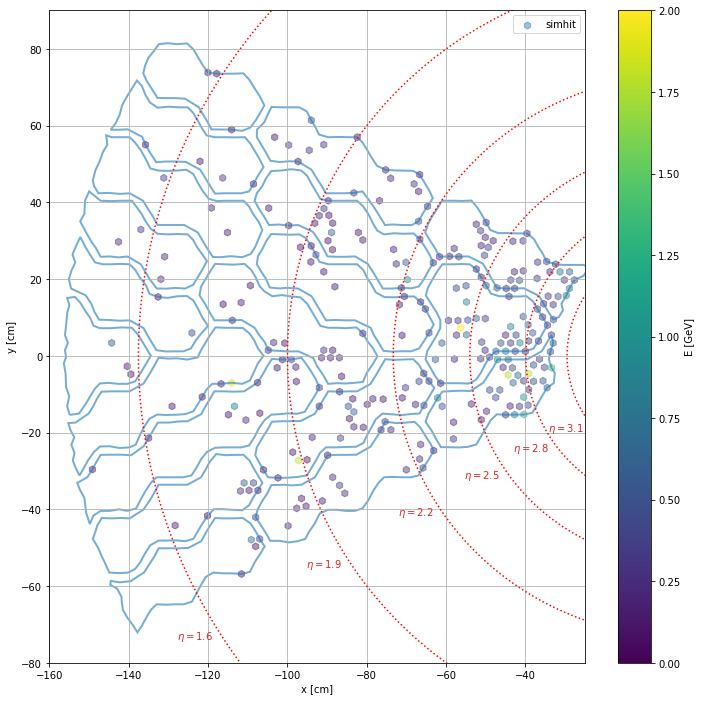

In [15]:
# get event and plot it 
patch_file = open(f'data/v1/panel_patches_zplus_{layer}.pkl', 'rb')
patches = pickle.load(patch_file)
patch_file.close()

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')
for p, ashape in patches[sector].items():
    col = 'C0'
    patch = PolygonPatch(ashape, fill=False, ec=col, linestyle='-', linewidth=2, label='_nolegend_', alpha=0.6)
    ax.add_patch(patch)

df_skim = data[0].query(f'sector == {sector} and layer == {layer} and zside > 0')

#mask = df_skim.sim_e > 0
#sim_scat  = ax.scatter(df_skim[mask].x, df_skim[mask].y, c=df_skim.sim_e[mask], 
#                       cmap='viridis', 
#                       marker='*', 
#                       vmin=0.,
#                       vmax=2.,
#                       s=85, 
#                       alpha=1.
#                      )
reco_scat = ax.scatter(df_skim.x, df_skim.y, c=df_skim.reco_e, 
                       cmap='viridis', 
                       marker='h', 
                       vmin=0.,
                       vmax=2.,
                       s=50, 
                       alpha=0.45
                      )

ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

cbar_reco = plt.colorbar(reco_scat, ax=ax, label='E [GeV]')
cbar_reco.set_alpha(1)
cbar_reco.draw_all()

#cbar_sim = plt.colorbar(sim_scat, ax=ax, label=r'$E_{sim}$')
plt.legend(['simhit', 'recohit'])
plt.grid()

plt.savefig('plots/hits_test.png')
plt.show()

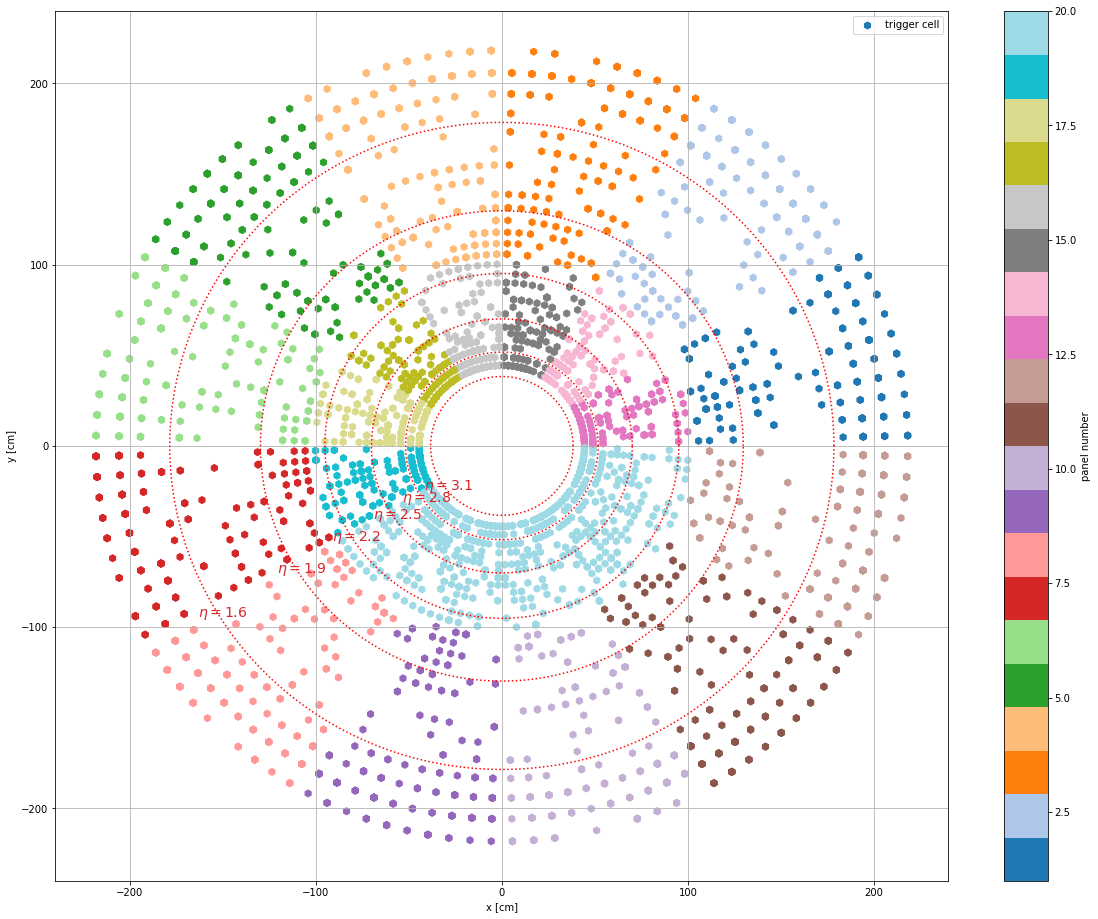

In [39]:
# get event and plot it 
fig, ax = plt.subplots(1, 1, figsize=(20, 16), facecolor='white')

df_skim = df_all.query(f'layer == 41 and zside > 0')
reco_scat = ax.scatter(df_skim.x, df_skim.y, c=df_skim.panel, 
                       cmap='tab20', 
                       marker='h', 
                       vmin=1.,
                       vmax=20.,
                       s=50, 
                       alpha=1.
                      )

#ax.set_ylim(-80, 90)
#ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(0, 2*np.pi, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=14)

cbar_reco = plt.colorbar(reco_scat, ax=ax, label='panel number')
cbar_reco.set_alpha(1)
cbar_reco.draw_all()

#cbar_sim = plt.colorbar(sim_scat, ax=ax, label=r'$E_{sim}$')
plt.legend(['trigger cell',])
plt.grid()

plt.savefig('plots/crude_panel_map.pdf')
plt.show()

In [ ]:
# plot transverse/longitudinal view
ievt = 0
df = data[ievt].query('z > 0').copy()
df['r'] = np.sqrt(df.x**2 + df.y**2)
genpart = gen[ievt].query('1.6 < eta < 3.0')

fig, axes = plt.subplots(1, 2, figsize=(16, 8), facecolor='white')
ax = axes[0]
ax.scatter(df.z, df.y, s=5*df.reco_e, c='C1', marker='h', alpha=0.5)
ax.scatter(df.z, df.y, s=10*df.sim_e, c='C0', marker='h')
ax.scatter(genpart.shape[0]*[320,], genpart.ey, s=50, c='C4', marker='*')

ax.plot([319, 319], [-300, 300], c='k', linestyle='--', label='_nolegend_')
ax.plot([357, 357], [-300, 300], c='k', linestyle='--', label='_nolegend_')
ax.plot([420, 420], [-300, 300], c='k', linestyle='--', label='_nolegend_')

ax.set_xlabel('z [cm]')
ax.set_ylabel('y [cm]')
ax.set_ylim(-200, 200)
ax.text(325, 175, 'EE')
ax.text(360, 175, 'HF')
ax.text(425, 175, 'HB')
ax.grid()

ax = axes[1]
ax.scatter(df.x, df.y, s=5*df.reco_e, c='C1', marker='h', alpha=0.5)
ax.scatter(df.x, df.y, s=10*df.sim_e, c='C0', marker='h')
ax.scatter(genpart.ex, genpart.ey, s=50, c='C4', marker='*')
    
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_xlim(-175, 175)
ax.set_ylim(-175, 175)
ax.grid()

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(0, 2*np.pi, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)


ax.legend(['recohit', 'simhit', 'gen particles'])

plt.tight_layout()
plt.show()

In [ ]:
# plot transverse/longitudinal view
ievt = 0
df = data[ievt].query('z > 0').copy()
df['r'] = np.sqrt(df.x**2 + df.y**2)
genpart = gen[ievt].query('1.6 < eta < 3.0')

fig, axes = plt.subplots(1, 1, figsize=(8, 8), facecolor='white')
ax = axes
ax.scatter(df.phi, df.eta, s=10*df.reco_e, c='C1', marker='h', alpha=0.5)
ax.scatter(df.phi, df.eta, s=10*df.sim_e, c='C0', marker='h')
ax.scatter(genpart.phi, genpart.eta, s=50, c='C4', marker='*')

ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\eta$')
ax.grid()

ax.legend(['recohit', 'simhit', 'gen particles'], 
          bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=3, mode="expand", borderaxespad=0.)


plt.tight_layout()
plt.show()